# PUI2016 HW4 - jp4772
## Assignment 4

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

import os

%matplotlib inline

I will be testing the distribution of Citibike rider ages in two sets:

- male and female
- day and night

Using 3 tests: KS, Pearson's, and Spearman's.

The significance level for all 3 tests will be $\alpha = 0.05$.

## Data Download and Prep

In [129]:
if os.getenv("PUIDATA"):
    data_path = os.getenv("PUIDATA")
else:
    os.system('mkdir data')
    data_path = "./data"
    
# Download trip data for 6 months from Jan 2016 to June 2016. At the time of this writing (Oct 2, 2016), 
# these are the six latest months available.

dates = ['201601', '201602', '201603', '201604', '201605', '201606']
data_files = [date + "-citibike-tripdata.zip" for date in dates]

for f in data_files:
    os.system("curl -o " + data_path + "/" + f + " https://s3.amazonaws.com/tripdata/" + f)

In [239]:
# Load data files into a giant dataframe
df = pd.concat([pd.read_csv(data_path + "/" + file, header=0) for file in data_files])

# Reset index as the concatenation of several files runs havoc
df.reset_index(drop=True, inplace=True)

In [240]:
# Check dataframe for sanity
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,923,1/1/2016 00:00:41,1/1/2016 00:16:04,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22285,Subscriber,1958,1
1,379,1/1/2016 00:00:45,1/1/2016 00:07:04,476,E 31 St & 3 Ave,40.743943,-73.979661,498,Broadway & W 32 St,40.748549,-73.988084,17827,Subscriber,1969,1
2,589,1/1/2016 00:00:48,1/1/2016 00:10:37,489,10 Ave & W 28 St,40.750664,-74.001768,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,21997,Subscriber,1982,2
3,889,1/1/2016 00:01:06,1/1/2016 00:15:56,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22794,Subscriber,1961,2
4,1480,1/1/2016 00:01:12,1/1/2016 00:25:52,2006,Central Park S & 6 Ave,40.765909,-73.976342,2006,Central Park S & 6 Ave,40.765909,-73.976342,14562,Subscriber,1952,1


In [241]:
# Drop all rows where we do not have a birth year
df.dropna(inplace=True, subset=['birth year'])

In [242]:
# Generate age column
df['age'] = 2016 - df['birth year']

In [243]:
len(df[df['age'] > 100])

2075

In [244]:
# Over 2000 rides by riders over 100 feels much too high and a data issue.
# Only use data for riders under 100. 
df = df[df['age'] < 100]

In [245]:
len(df[df['gender'] == 0])

11355

In [246]:
# Drop all rows where gender is not defined
df = df[df['gender'] != 0]

In [247]:
# Convert starttime of trip to datetime data type to be able to work with it better
df["datetime"] = pd.to_datetime(df["starttime"], format="%m/%d/%Y %H:%M:%S")

In [248]:
# Generate age of male and female riders column
# 1 = male
# 2 = femaile
df['ageM'] = 2016 - df['birth year'][df['gender'] == 1]
df['ageF'] = 2016 - df['birth year'][df['gender'] == 2]

In [249]:
# Generate age by day or night
df['ageDay'] = 2016 - df['birth year'][(df["datetime"].dt.hour >= 7) & (df["datetime"].dt.hour < 19)]
df['ageNight'] = 2016 - df['birth year'][(df["datetime"].dt.hour >= 19) | (df["datetime"].dt.hour < 7)]

In [265]:
# Generate day/night column
# 1 = day
# 2 - night
df.loc[(df["datetime"].dt.hour >= 7) & (df["datetime"].dt.hour < 19), 'time'] = 1
df.loc[(df["datetime"].dt.hour >= 19) | (df["datetime"].dt.hour < 7), 'time'] = 2

In [257]:
# Drop unneeded columns
df.drop(['tripduration',
         'starttime', 
         'stoptime', 
         'start station id', 
         'start station name', 
         'start station latitude',
         'start station longitude',
         'end station id', 
         'end station name', 
         'end station latitude',
         'end station longitude',
         'bikeid',
         'usertype'], axis=1, inplace=True)

df['ageM'].dropna(inplace=True)
df['ageF'].dropna(inplace=True)
df['ageDay'].dropna(inplace=True)
df['ageNight'].dropna(inplace=True)

In [266]:
df.head()

,birth year,gender,age,datetime,ageM,ageF,ageDay,ageNight,time
0,1958,1,58,2016-01-01 00:00:41,58,nan,nan,58,2
1,1969,1,47,2016-01-01 00:00:45,47,nan,nan,47,2
2,1982,2,34,2016-01-01 00:00:48,nan,34,nan,34,2
3,1961,2,55,2016-01-01 00:01:06,nan,55,nan,55,2
4,1952,1,64,2016-01-01 00:01:12,64,nan,nan,64,2


## Data Exploration

In [267]:
pd.set_option('display.float_format', '{:.8g}'.format)
df.describe()

,birth year,gender,age,ageM,ageF,ageDay,ageNight,time
count,5012979,5012979,5012979,3834498,1178481,3870015,1142964,5012979
mean,1977.1328,1.235086,38.867208,39.234744,37.67133,39.448443,36.899176,1.228001
std,11.585095,0.42405258,11.585095,11.589158,11.490801,11.656062,11.118134,0.41954327
min,1917,1,16,16,16,16,16,1
25%,1969,1,30,32,nan,32,nan,1
50%,1980,1,36,43,nan,43,nan,1
75%,1986,1,47,65,nan,63,nan,1
max,2000,2,99,99,95,99,99,2


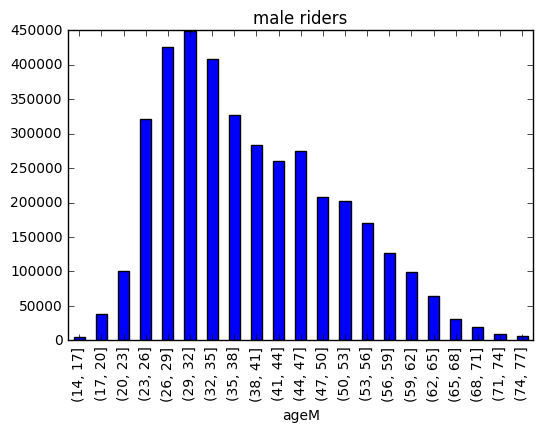

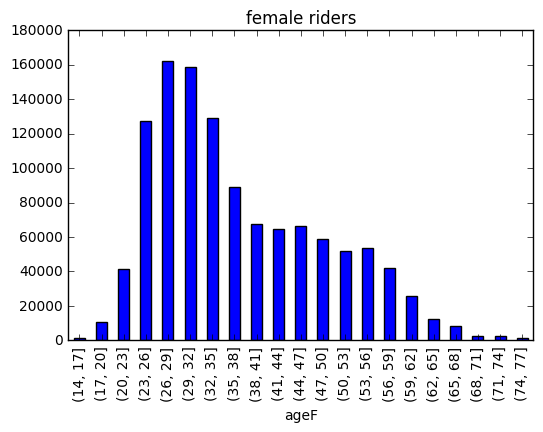

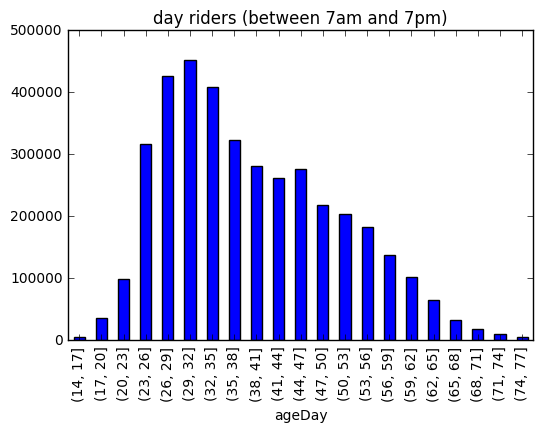

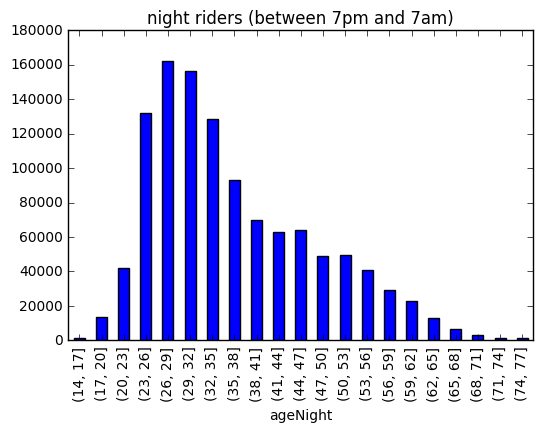

In [253]:
# Histogram plot by age for male, female, day, and night riders
# Set bins to be by 3 year increments between 17 and 80
bins = np.arange(14, 80, 3)

axM = df.ageM.groupby(pd.cut(df.ageM, bins)).agg([np.count_nonzero]).plot(kind='bar', legend=False)
axM.set_title("male riders")

axF = df.ageF.groupby(pd.cut(df.ageF, bins)).agg([np.count_nonzero]).plot(kind='bar', legend=False)
axF.set_title("female riders")

axDay = df.ageDay.groupby(pd.cut(df.ageDay, bins)).agg([np.count_nonzero]).plot(kind='bar', legend=False)
axDay.set_title("day riders (between 7am and 7pm)")

axNight = df.ageNight.groupby(pd.cut(df.ageNight, bins)).agg([np.count_nonzero]).plot(kind='bar', legend=False)
axNight.set_title("night riders (between 7pm and 7am)")

### Figure 1: Histogram distribution of riders' age by gender and time of day

          count_nonzero
ageM                   
(14, 17]   2.190723e-05
(17, 20]  0.00089582546
(20, 23]   0.0078803695
(23, 26]    0.032183028
(26, 29]    0.058682037
(29, 32]    0.076061979
(32, 35]    0.079228815
(35, 38]    0.069215675
(38, 41]    0.052412256
(41, 44]     0.03932718
(44, 47]    0.024194231
(47, 50]    0.019990709
(50, 53]    0.010939232
(53, 56]    0.012226592
(56, 59]     0.01474912
(59, 62]    0.010772954
(62, 65]   0.0045276434
(65, 68]   0.0034558986
(68, 71]  0.00062451945
(71, 74]  0.00020176177
(74, 77]              0


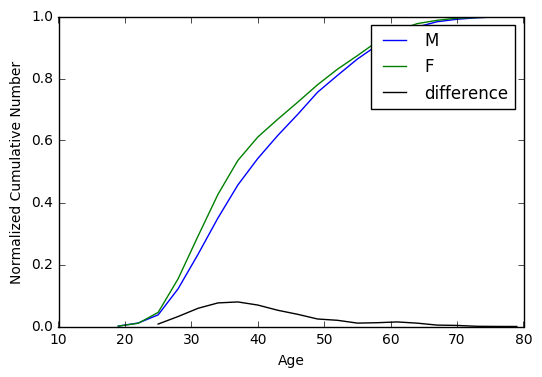

In [254]:
csM=df.ageM.groupby(pd.cut(df.ageM, bins)).agg([np.count_nonzero]).cumsum()
csF=df.ageF.groupby(pd.cut(df.ageF, bins)).agg([np.count_nonzero]).cumsum()

print (np.abs(csM / csM.max()-csF / csF.max()))

plt.plot(bins[:-1] + 5, csM / csM.max(), label = "M")
plt.plot(bins[:-1] + 5, csF / csF.max(), label = "F")
plt.plot(bins[:-1] + 5, np.sqrt(csF / csF.max() - csM / csM.max())**2, 'k-',
        label = "difference")

plt.xlabel("Age")
plt.ylabel("Normalized Cumulative Number")
plt.legend()

### Figure 2: Cumulative distribution of Citibike riders' ages by gender

          count_nonzero
ageDay                 
(14, 17]  1.7332625e-05
(17, 20]   0.0024684673
(20, 23]    0.013398789
(23, 26]    0.046861082
(26, 29]    0.078472696
(29, 32]    0.098515223
(32, 35]     0.10522409
(35, 38]     0.10308429
(38, 41]    0.091494775
(41, 44]    0.078879421
(44, 47]    0.063418148
(47, 50]     0.04961062
(50, 53]    0.040261972
(53, 56]    0.028729224
(56, 59]    0.018731232
(59, 62]     0.01227089
(62, 65]   0.0068660316
(65, 68]   0.0041896782
(68, 71]   0.0019364003
(71, 74]  0.00060132777
(74, 77]              0


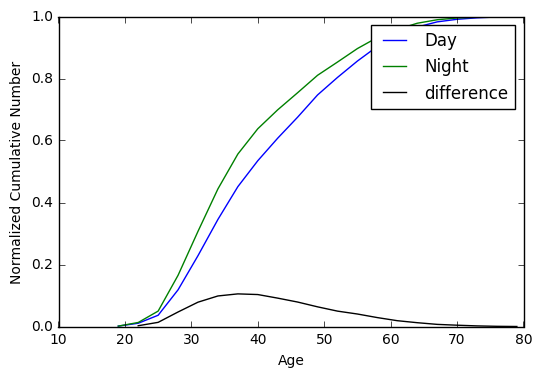

In [255]:
csDay=df.ageDay.groupby(pd.cut(df.ageDay, bins)).agg([np.count_nonzero]).cumsum()
csNight=df.ageNight.groupby(pd.cut(df.ageNight, bins)).agg([np.count_nonzero]).cumsum()

print (np.abs(csDay / csDay.max()-csNight / csNight.max()))

plt.plot(bins[:-1] + 5, csDay / csDay.max(), label = "Day")
plt.plot(bins[:-1] + 5, csNight / csNight.max(), label = "Night")
plt.plot(bins[:-1] + 5, np.sqrt(csNight / csNight.max() - csDay / csDay.max())**2, 'k-',
        label = "difference")

plt.xlabel("Age")
plt.ylabel("Normalized Cumulative Number")
plt.legend()

### Figure 3: Cumulative distribution of Citibike riders' ages by time of day

## KS Test

In [258]:
ks_gender = scipy.stats.ks_2samp(df.ageM, df.ageF)
ks_time = scipy.stats.ks_2samp(df.ageDay, df.ageNight)

print "gender: ", ks_gender
print "time of day: ", ks_time

gender:  Ks_2sampResult(statistic=0.10466488872313692, pvalue=0.0)
time of day:  Ks_2sampResult(statistic=0.12935625141782509, pvalue=0.0)


A '2-sample KS Test' like the one above checks to see if the 2 samples it is given are part of the same continuous distribution. The p-value it returns is a confidence level of whether or not it is possible to reject the Null hypothesis that both samples are part of the same distribution.

The wording is a bit confusing since we're dealing with a double negative.

In this case the p-value is under our signifance level (in our case 0.05) for both our pairs of samples meaning that the each pair of sample are of different distributions (the Null hypothesis being that they are the same).

Thus, for both pairs for samples in terms of **gender** and **time of day** we can confidently **reject** the Null hypothesis.

## KS Test with subsample of data (1 ride every 200)

In [259]:
# Sample both ageM and ageF by a fraction of 1/200 and run the KS 2-sample test once again
ks_sample_gender = scipy.stats.ks_2samp(df["ageM"].sample(frac=0.005), df["ageF"].sample(frac=0.005))
ks_sample_time = scipy.stats.ks_2samp(df["ageDay"].sample(frac=0.005), df["ageNight"].sample(frac=0.005))

print "gender:", ks_sample_gender
print "time of day:", ks_sample_time

gender: Ks_2sampResult(statistic=0.10043662339102002, pvalue=4.6623455486487929e-40)
time of day: Ks_2sampResult(statistic=0.12732385196035123, pvalue=8.8856857792175388e-63)


The Null hypothesis is once again **rejected**, as the p-value for both pairs is still very low (much lower then are $\alpha = 0.05$), though slightly higher then when testing the entire two samples above.

## Pearson's Test for correlation

For a Pearson's test we'll use the entire dataframe since both sets of data need to be the same length. A Pearson's  test looks for linear correlation between two variables and produces what is called a Pearson’s correlation coefficient. Since this is a two-tailed test, meaning that correlation can be both negative and positive, the Null hypothesis must be stated as a distance from the mean. The p-value given in a Pearson's test is the probabaility that an uncorrelated dataset would not produce the same coefficient.

As such, the Null hypothesis for these test can be stated as such:

$H_{gender}$: An uncorrelated dataset's Pearson correlation is *at least as extreme* as the Pearson correlation between a riders age and their gender.

$H_{time}$: An uncorrelated dataset's Pearson correlation is *at least as extreme* as the Pearson correlation between a riders age and the time of day they ride.

In [273]:
pt_gender = scipy.stats.pearsonr(df["age"], df["gender"])
print "gender:", pt_gender

pt_time = scipy.stats.pearsonr(df["age"], df["time"])
print "time of day:", pt_time

gender (-0.057226088296109846, 0.0)
time of day: (-0.092319277411370707, 0.0)


The last number in both the Pearson's tests about give us a p-value of 0.0, which is certainly below are $\alpha = 0$. Thus, we **reject** the Null hypothesis that an uncorrelated dataset would produce at least as extreme a correlation, we can then say that it appears these datasets are indeed correlated.

In practical terms what this demonstrates is that as the age of the rider increases, they tend to be more male and they tend to be willing to ride at night.

## Spearman's test for correlation

A Spearman's test ranks ordinal variables and then tests the correlation between the differences of these rankings. We'll use the whole dataframe again for this analysis as the number of observations for both need to be the same number. A Spearman's test is really the best use for our dataset since our dependent variables are both binomial (male/female, day/night), but we'll use it regardless just to show how it works.

The Null hypothesis for this test can best stated as:

$H_{gender}$: An uncorrelated dataset's Spearman's correlation is *at least as extreme* as the Spearman's correlation between a riders age and their gender.

$H_{time}$: An uncorrelated dataset's Spearman's correlation is *at least as extreme* as the Spearman's correlation between a riders age and the time of day they ride.

In [274]:
sp_gender = scipy.stats.spearmanr(df["age"], df["gender"])
sp_time = scipy.stats.spearmanr(df["age"], df["time"])

print "gender:", sp_gender
print "time of day:", sp_time

gender: SpearmanrResult(correlation=-0.063881970195547408, pvalue=0.0)
time of day: SpearmanrResult(correlation=-0.097038294979449019, pvalue=0.0)


Once again, we get a very strong p-value under our $\alpha = 0.05$ so we can **reject** the Null hypothesis that an uncorrelated dataset would produce a similar correlation. Though the correlation is small, it exists. Thus we can say that as the age of a rider increases, it is more likley that they are male and that they are willing to ride at night.